# Population / Cohort Survival Curves (Kaplan-Meier)

Kaplan-Meier estimator is a powerful non-parametric method to estimate Survival Curves for a Population / Cohort. It is implemented using David Camerons [lifelines package](https://lifelines.readthedocs.io/en/latest/index.html).

After a first small demonstration of the KM estimator on tiny dummy data, the estimator is fitted to data of telco customers, first as a whole and then in cohorts. The latter is also very interesting to see which features have importance when it comes to survival duration / churn rates. This will be further explored in the next notebook.

- This notebooks owes very much to this [blogpost](https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e) from Anurag Pandey, that gives some nice additional explanations. 
- The deep dive section at the end is taken from Lauren Oldja's [repository](https://github.com/loldja/loldja.github.io/blob/master/assets/code/blog/Kaplan%20Meier%20demo.ipynb).


### Kaplan-Meier

For background, see [Rich et al (2010)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3932959/), [Singh et all (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3227332/)
- Estimates the “survival function” for a cohort of subjects 
- Does not provide an estimate of the magnitude of the difference in survival for the cohorts being compared 
- Each observation (case, customer) should have one "birth" (activation) and one "death" (churn)


**Pros**:
- Minimal feature set needed. Only needs the time which event occurred (death or censorship) and the lifetime duration between birth and event.
- Many time-series analyses are tricky to implement. Kaplan-Meier only needs all of the events to happen within the same time period of interest
- Handles class imbalance automatically (any proportion of deaths-to-censored events is okay)
- Because it is a non-parametric method, few assumptions are made about the underlying distribution of the data

**Cons**:
- Cannot estimate the magnitude in difference of the survival-predictor relationship of interest (no hazard ratio or relative risk)
- Cannot account for multiple factors simultaneously for each subject in the time to event study, nor control for confounding factors
- Assumes independence between censoring and survival, meaning that at time t, those who have been censored should have the same prognosis as those who have not been censored.
- Because it is a non-parametric model, it is not as efficient or accurate as competing techniques on problems where the underlying data distribution is known


### Data Sources

- `data/raw/Telco-Customer-Churn.xlsx`: Data from IBM Watson Analytics, can be downloaded [here](https://www.ibm.com/communities/analytics/watson-analytics-blog/Telco-Customer-Churn/).

### Data Output

- `'data/interim/telco_customer_churn.csv'`: Cleaned data, will be reused in the second notebook.

### Changes

- 2019-02-22: Start and terminate notebook

---

### Import libraries, load data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test # survival statistical testing

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import Image # for image towards the end
from IPython.display import display
pd.options.display.max_columns = 100

In [2]:
# Load data 
data = pd.read_excel('data/raw/Telco-Customer-Churn.xlsx')

## 0) Small demo with dummy data

The example below shows the data of 6 users of a website. Thy visit the website and leave after few minutes. Thus, event of interest is the time in which a user leaves the website. Time of origin is defined as the time of opening the website by a user and the time scale is in minutes. The study starts at time t=0 and ends at time t=6 minutes.

**Censorship:** During the study period, event happened with 4 out of 6 users, while two users continued and the event didn’t happen till the end of the study; such data is called _censored data_. In case of censorship, we don’t know at what time the event will occur, but still we are using that data to estimate the probability of survival. If we did not include the censored data, then it is highly likely that our estimates would be highly biased and under-estimated. _The inclusion of censored data to calculate the estimates, makes the Survival Analysis very powerful, and it stands out as compared to many other statistical techniques._

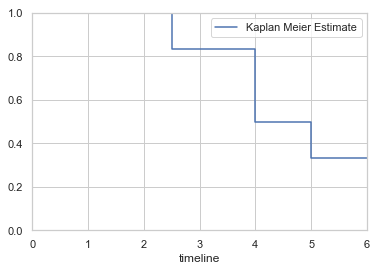

In [3]:
# Create example data 
durations = [5,6,6,2.5,4,4]
event_observed = [1, 0, 0, 1, 1, 1]

# Create and fit a kmf object
kmf = KaplanMeierFitter() 
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
kmf.plot(ci_show=False, ylim=(0,1));  # ci_show is meant for confidence interval, our data set is too tiny

## 1) Ananyze Telco Customer Churn 


In [4]:
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

None

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Clean data

- Change dtypes
- encode churn column (is our 'event')
- check TotalCharges column, should be float

In [5]:
# Create a list of categorical columns
cat_cols= [i  for i in data.columns if data[i].dtype == object]
cat_cols.remove('customerID')  ## customerID is unique for all the rows.

# Replace empty strings in TotalCharges with NaN
data['TotalCharges'].replace(' ', np.NaN, inplace=True)

# Convert dtypes
data = cleaning.change_dtypes(data, 
                              cols_to_category=cat_cols, 
                              cols_to_float=['TotalCharges'])

In [6]:
# Check missing values
cleaning.list_NaN(data)

List of missing values per column:
TotalCharges: 11 (0.16%)


In [7]:
# Impute NaN with the median value
data.TotalCharges.fillna(value=data['TotalCharges'].median(),inplace=True)

# Check missing values
cleaning.list_NaN(data)

No empty cells in DataFrame.


In [8]:
# Encode Churn
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

In [9]:
# Save to disc
data.to_csv('data/interim/telco_customer_churn.csv', index=False)

### Create overall KaplanMeier curve

(Note: If you don't have a tenure column but start and end dates, then there is a transform function in the lifelines package.)

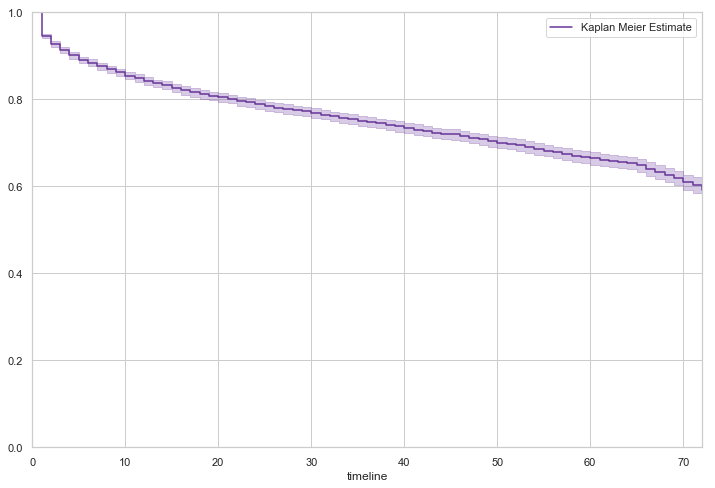

In [10]:
T = data['tenure']  # Time to event data of censored and event data
E = data['Churn']  # It has the churned (1) and censored is (0)

km = KaplanMeierFitter() 
km.fit(T, E, label='Kaplan Meier Estimate')
km.plot(figsize=(12,8), c=color, ylim=(0,1));

### Create Kaplan Meier Curves for Cohorts

#### By contract type

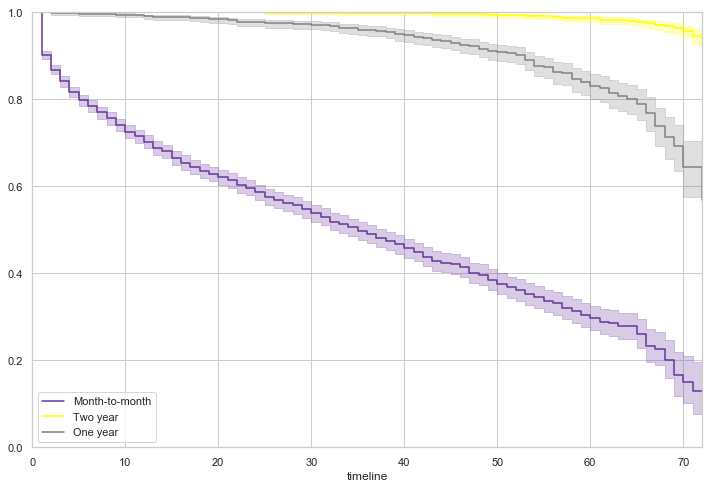

In [11]:
# Create 3 cohorts from the 'Contract' column - Note: there is also an option with pd.groupby
groups = data['Contract']             
ix1 = (groups == 'Month-to-month')   
ix2 = (groups == 'Two year')         
ix3 = (groups == 'One year')         


# Fit the data for each cohort
kmf.fit(T[ix1], E[ix1], label='Month-to-month')
ax = kmf.plot(c=color, figsize=(12,8))
kmf.fit(T[ix2], E[ix2], label='Two year')         
ax1 = kmf.plot(ax=ax, c='yellow')
kmf.fit(T[ix3], E[ix3], label='One year')        
kmf.plot(ax=ax1, c='grey', ylim=(0,1));

#### By subscription for streaming

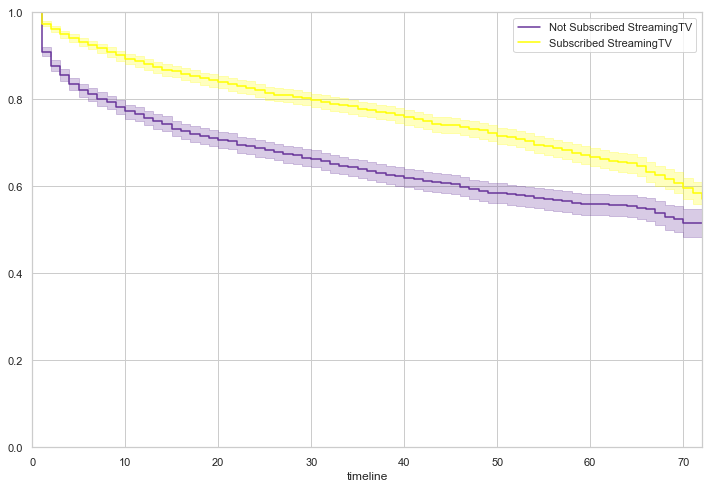

In [12]:
# Create 2 cohorts from the 'StreamingTV' column
groups = data['StreamingTV']   
i1 = (groups == 'No')     
i2 = (groups == 'Yes')

# Fit the data for each cohort
kmf.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf.plot(c=color, figsize=(12,8))
kmf.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf.plot(ax=a1, c='yellow', ylim=(0,1));

---

## 2) Deep dive: Cohort analysis and plot styling

By number of lines

### Cleaning and EDA

In [13]:
# Check group variable
data['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [14]:
# Drop 'No phone service'
data = data.loc[data['MultipleLines'] != 'No phone service']

# Check result
data['MultipleLines'].value_counts() / len(data)

No                  0.532935
Yes                 0.467065
No phone service    0.000000
Name: MultipleLines, dtype: float64

In [15]:
# Recode group variable
data["MultipleLines"] = data['MultipleLines'].map({'Yes': 1, 'No': 0})

In [16]:
# Look at tenure - Note: this is not time series data, 
# so we will assume all customers start at t = 0 and continue until t = tenure
data['tenure'].describe()

count    6361.000000
mean       32.439082
std        24.595120
min         0.000000
25%         9.000000
50%        29.000000
75%        56.000000
max        72.000000
Name: tenure, dtype: float64

### Create Kaplan-Meier Curves
... with hardcore plot styling ...

In [17]:
kmf = KaplanMeierFitter()
T = data['tenure'] #duration
C = data["Churn"] #censorship - 1 if death/churn is seen, 0 if censored

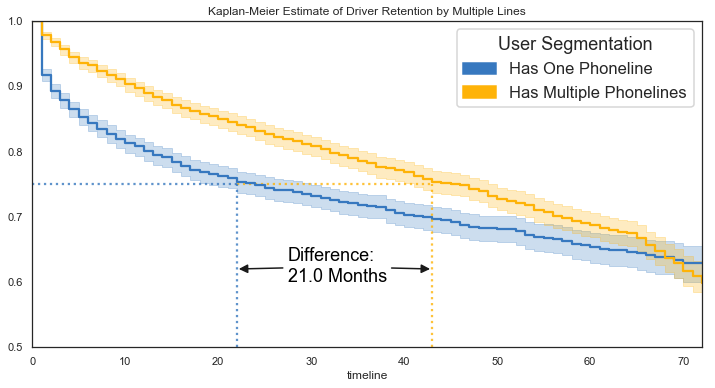

In [18]:
import matplotlib.patches as mpatches #for custom legends

palette = ["windows blue", "amber"]
sns.set_palette(sns.xkcd_palette(palette))
sns.set_style('white')

# SET UP PLOT
ax = plt.subplot(111)
plt.title('Kaplan-Meier Estimate of Driver Retention by Multiple Lines')
sns.set_context("talk")

d={} # to store the models
vlines = []
i=0

# PLOT FITTED GRAPH
# loop through segmentation variable, plot on same axes
for segment in data['MultipleLines'].unique(): 
    ix = data['MultipleLines'] == segment
    d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
    ax = kmf.plot(ax=ax, figsize=(12,6))

    ax.set_xlim([T.min(),T.max()])
    ax.set_ylim([0.5,1])
    
    y_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna().index[0]
    ymax_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna()[i][y_]
    
    vlines.append([y_, ymax_])
    i+=1

# PLOT ANNOTATION
# For each intercept, plot a horizontal and a vertical line up to the fitted curve
xmin_= 0
for i, xy in enumerate(vlines):
    xmax_ = xy[0]
    color="xkcd:{}".format(palette[i])
    
    plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') # axes fractional
    plt.hlines(y=.75, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') # axes data coordinates
    xmin_ += xmax_ # to avoid overlapping hlines

# Position text label
difference = vlines[1][0]-vlines[0][0]
label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07 #midpoint (minus .07 centering factor)
label_frac_y = 0.2

# Label first line
ax.annotate('Difference:\n{} Months'.format(difference), 
  xy=(vlines[0][0],.62), xycoords='data', color='white',
  xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
  arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                  fc="k", ec="k")
           )

# label second line    
ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[1][0],.62), xycoords='data', color='black',
      xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec='k')
           )

# LEGEND
# Override default legend
patches = [ mpatches.Patch(color="xkcd:windows blue", label='Has One Phoneline'),
            mpatches.Patch(color="xkcd:amber", label='Has Multiple Phonelines')
          ]
plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');

The graph clearly shows that there is a difference in tenure between "single line" and "multiple line" telco users. Since the confidence interals also appear on the graph, we can see that the difference is statistically significant from t > 0 until approximately t= 52 months, after which the churn rates becomes the same, within the margin of error.

### Get the hazard ratio - _I cannot really interpret this_

Our survival curves do not follow the constant proportionality assumption (they cannot because they cross, and we can also see varying distances between the curves throughout). Conventionally, this would mean that a logrank test is not an appropriate measure for estimating the hazard ratio. This presentation by Stone (2015) makes a compelling argument that hazard ratios on nonproportionality are still readily interpretable. This has, however, been a source of controversy in the biostatistics field. Alternative methods such as time-splitting have been proposed, see: Bouliotis & Billingham (2011)

In [19]:
# Image Credit: https://en.wikipedia.org/wiki/Log-rank_test
Image(url= "https://wikimedia.org/api/rest_v1/media/math/render/svg/68750c8d50ac1d055b3ddcc67a05de43b40fdebf")

In [20]:
# Run logrank test
multi = (data["MultipleLines"] == 1)
results = logrank_test(T[multi], T[~multi], C[multi], C[~multi], alpha=0.99 ) #at 99% confidence level
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99

---
 test_statistic      p  -log2(p)
          31.26 <0.005     25.40


In [21]:
Z = results.test_statistic
D = C.sum() # number of events observed

hazard_ratio = np.exp(Z*np.sqrt(4/D))
print(hazard_ratio)

4.558110268130183


According to this calculation the risk of churn is 4.5 times higher in users with only one phoneline compared to users with multiple lines.

---